# Document similarity (Quora question pair similarity)
 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import nltk
import spacy
import contractions
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from fuzzywuzzy import fuzz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
warnings.filterwarnings("ignore")

C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\LENOVO\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
df = pd.read_csv("data/train.csv")
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_test = pd.read_csv("data/test.csv")
df_test.head(5)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3563475 entries, 0 to 3563474
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   test_id    object
 1   question1  object
 2   question2  object
dtypes: object(3)
memory usage: 81.6+ MB


In [7]:
df_test.isnull().sum()

test_id      0
question1    4
question2    6
dtype: int64

In [5]:
df['question1'] = df['question1'].astype(str).fillna('India')
df['question2'] = df['question2'].astype(str).fillna('India')

We are provided two datasets one is train.csv that has 6 columns, id, qid1, qid2, question1, question2 and is_duplicate with ~4,00,000 entries and the oner is test.csv with three columns test_id, question2, question1. Our object is to train a model with the object of getting a 0 or 1 outbut of is_duplicate andf creating and filling the column with the 0 or 1 in the "test.csv" which contains ~35,00,000 rows

Primary Basic Infrence:
for reading the first rows of the datasets I will make primary analysis going forward:
1. The datasets have undergone basic primary processing and is mostly not noisy or incomplete.
2. The qoution words such as "what", "how", "where" etc may be very importent in determing "is_duplicate"
3. Commen stopword as well as keywords may both be importent in determing the binnary



# Exploratory Data Analysis (EDA):

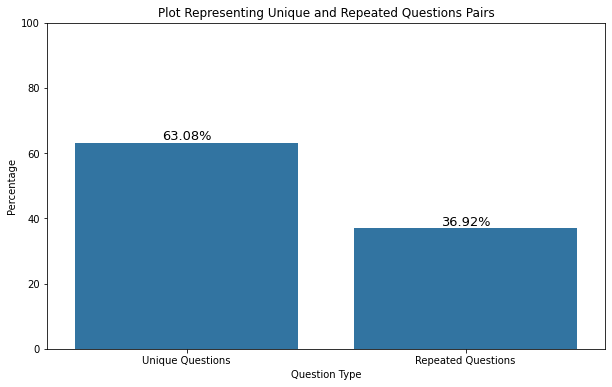

In [9]:
unique_qs = df['is_duplicate'].value_counts()[0]
not_unique_qs = df['is_duplicate'].value_counts()[1]

total_qs = unique_qs + not_unique_qs
unique_qs_pct = (unique_qs / total_qs) * 100
not_unique_qs = (not_unique_qs / total_qs) * 100

x = ["Unique Questions", "Repeated Questions"]
y = [unique_qs_pct, not_unique_qs]

plt.figure(figsize=(10, 6))
plt.title("Plot Representing Unique and Repeated Questions Pairs")
sns.barplot(x=x, y=y)

# Annotate bars with percentages
for i, value in enumerate(y):
    plt.text(i, value + 1, f'{value:.2f}%', ha='center', fontsize=13)

plt.ylabel('Percentage')
plt.xlabel('Question Type')
plt.ylim(0, 100)  
plt.show()

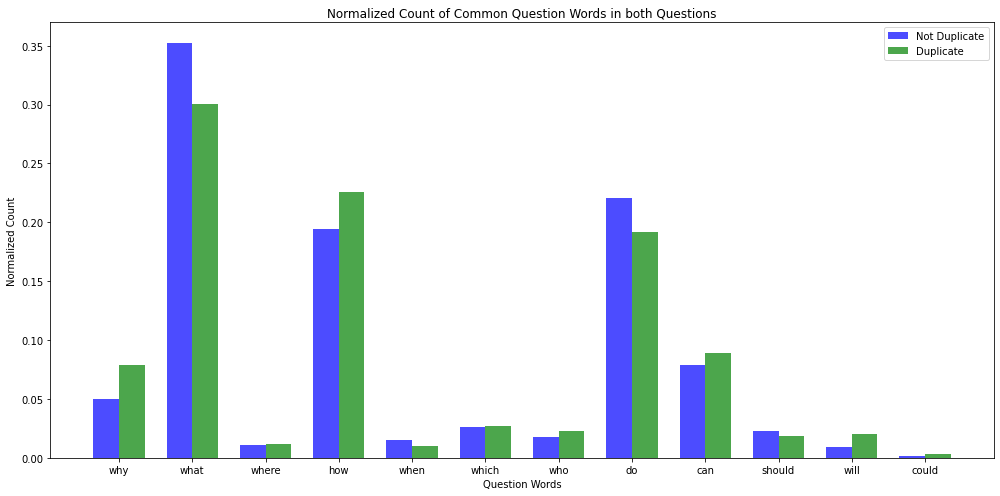

In [10]:

question_words = ['why', 'what', 'where', 'how', 'when', 'which', 'who', 'do', 'can', 'should', 'will', 'could']

def count_question_words(text, words):
    text = str(text).lower()
    return {word: text.count(word) for word in words}

for word in question_words:
    df[f'question1_{word}'] = df['question1'].apply(lambda x: count_question_words(x, question_words)[word] > 0)
    df[f'question2_{word}'] = df['question2'].apply(lambda x: count_question_words(x, question_words)[word] > 0)
    df[f'both_{word}'] = df[f'question1_{word}'] & df[f'question2_{word}']

counts = {}
for word in question_words:
    counts[word] = df.groupby('is_duplicate')[f'both_{word}'].sum()

counts_df = pd.DataFrame(counts).T
counts_df.columns = ['Not Duplicate', 'Duplicate']

# Normalize the counts
counts_df['Not Duplicate'] = counts_df['Not Duplicate'] / counts_df['Not Duplicate'].sum()
counts_df['Duplicate'] = counts_df['Duplicate'] / counts_df['Duplicate'].sum()

# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

bar_positions = range(len(counts_df))

ax.bar(bar_positions, counts_df['Not Duplicate'], width=0.35, label='Not Duplicate', color='blue', alpha=0.7)
ax.bar([p + 0.35 for p in bar_positions], counts_df['Duplicate'], width=0.35, label='Duplicate', color='green', alpha=0.7)

# X-axis labels
ax.set_xticks([p + 0.35 / 2 for p in bar_positions])
ax.set_xticklabels(counts_df.index)

ax.set_xlabel('Question Words')
ax.set_ylabel('Normalized Count')
ax.set_title('Normalized Count of Common Question Words in both Questions')
ax.legend()

plt.tight_layout()
plt.show()


In [11]:
# Function to calculate common word share
def common_words(row):
    q1_words = set(row['question1'].split())
    q2_words = set(row['question2'].split())
    common = q1_words.intersection(q2_words)
    return len(common) / ((len(q1_words) + len(q2_words)) / 2) if (len(q1_words) + len(q2_words)) > 0 else 0

df['common_word_share'] = df.apply(common_words, axis=1)


duplicate = df[df['is_duplicate'] == 1]
non_duplicate = df[df['is_duplicate'] == 0]

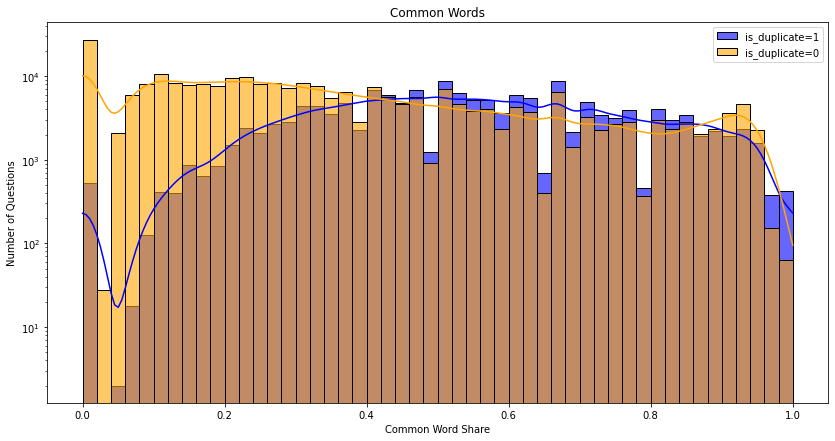

In [12]:
# Plot the histogram of common word shares
plt.figure(figsize=(14, 7))
sns.histplot(duplicate['common_word_share'], bins=50, kde=True, color='blue', label='is_duplicate=1', alpha=0.6)
sns.histplot(non_duplicate['common_word_share'], bins=50, kde=True, color='orange', label='is_duplicate=0', alpha=0.6)
plt.yscale('log', nonpositive='clip')
plt.title('Common Words')
plt.xlabel('Common Word Share')
plt.ylabel('Number of Questions')
plt.legend()
plt.show()


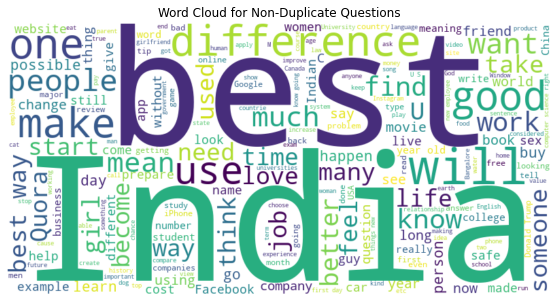

In [13]:
# Word Cloud for non-duplicate questions
non_duplicate_text = ' '.join(non_duplicate['question1']) + ' ' + ' '.join(non_duplicate['question2'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_duplicate_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Non-Duplicate Questions')
plt.show()


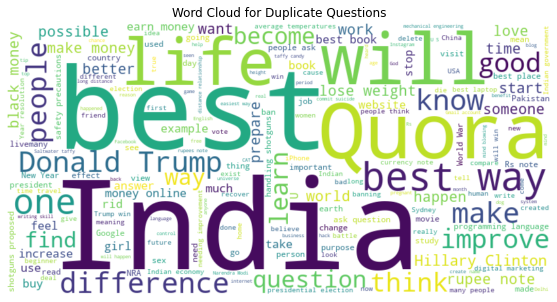

In [14]:
# Word Cloud for duplicate questions
duplicate_text = ' '.join(duplicate['question1']) + ' ' + ' '.join(duplicate['question2'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(duplicate_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Duplicate Questions')
plt.show()


Removing stopwords can affect the clarity of a model when done indiscriminately. Although overall improvements might be observed, certain word pairs could negatively impact the model’s performance by losing essential contextual information. For example, both *how is your college* and *where is your college* would reduce to *college* after stopword removal, thus losing the critical context provided by "how" and "where."

Based on this observation, we propose a hybrid approach:

   **Feature Extraction with Stopwords:**
        We will first extract relevant features while retaining stopwords. This ensures that the context and nuances are preserved.

   **Stopword Removal for Additional Features:**
        Then, we will apply stopword removal to extract features without stopwords. This helps reduce noise and focus on the core terms.

### Leveraging GloVe Pre-trained Embeddings:

Considering the importance of stopwords and previous attempts to improve model performance, we will use GloVe pre-trained embeddings to account for semantic meanings. GloVe embeddings capture the meaning of words in their context, which is crucial for understanding subtle differences. For instance:

    "What is One Coin?" refers to a specific entity named "OneCoin."
    "What is this one coin?" refers to a coin with a value of one, possibly accompanied by an image.

By leveraging GloVe embeddings, we can maintain the semantic integrity of sentences, ensuring that subtle differences are recognized and preserved. This approach also makes lemmatization and stemming unnecessary, as the embeddings inherently capture variations in word forms and meanings.
**Given that GloVe is so powerfull pre-processing like stemming, lemmzing and removing stopwords in generally unnessary**

### Feature Extraction:
The features extracted are:
1. **first_word_match** : the first worrd ( including stopwords) match
2. **last_word_match**: the last worrd ( including stopwords) match
3. **common_stopwords**: number of stopwords in both
4. **stopword_ratio** : The ratio of total number of stopwords with total number of words
5. **len_diff** : difference in the total number of words
6. **common_words** : number of non-stopwords in both
7. **total_words** : total words in both
8. **common_chars**: number of characters in both
9. **char_overlap** : number of chactors in both

In [3]:
# Initialize spaCy model, stopwords, and lemmatizer
nlp = spacy.load('en_core_web_md')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# # Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Now we that we gained some spicfic idea on the data we will begain the processing, feature extraction and finaly trainning.

we will re-load to avoid any changes during EDA and fill the Na values with the most commen words in the data set

In [5]:
df = pd.read_csv("data/train.csv")
df_test = df_test = pd.read_csv("data/test.csv")

df['question1'] = df['question1'].astype(str).fillna('will life India best qoura')
df['question2'] = df['question2'].astype(str).fillna('will life India best qoura')

df_test['question1'] = df_test['question1'].astype(str).fillna('Donald Trump people best way question ')
df_test['question2'] = df_test['question2'].astype(str).fillna('Donald Trump people best way question')


#### Data Preprocessing:

In [6]:
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions
    text = text.lower()  # Lowercase the text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    return tokens

def preprocess_text_advanced(text):
    text = contractions.fix(text)  # Expand contractions
    text = text.lower()  # Lowercase the text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

In [7]:
# Function to calculate features
def extract_features(df):
    
    # Basic preprocessing 
    df['q1_tokens_basic'] = df['question1'].apply(preprocess_text)
    df['q2_tokens_basic'] = df['question2'].apply(preprocess_text)

    # Advanced preprocessing 
    df['q1_tokens_advanced'] = df['question1'].apply(preprocess_text_advanced)
    df['q2_tokens_advanced'] = df['question2'].apply(preprocess_text_advanced)

    # First word matches
    df['first_word_match'] = df.apply(
        lambda x: 1 if x['q1_tokens_basic'] and x['q2_tokens_basic'] and x['q1_tokens_basic'][0] == x['q2_tokens_basic'][0] else 0, axis=1)

    # Last word matches
    df['last_word_match'] = df.apply(
        lambda x: 1 if x['q1_tokens_basic'] and x['q2_tokens_basic'] and x['q1_tokens_basic'][-1] == x['q2_tokens_basic'][-1] else 0, axis=1)

    # Common stopwords
    df['common_stopwords'] = df.apply(
        lambda x: len(set(x['q1_tokens_basic']).intersection(set(x['q2_tokens_basic'])).intersection(stop_words)) if x['q1_tokens_basic'] and x['q2_tokens_basic'] else 0, axis=1)

    # Ratio of stopwords to total words
    df['q1_len'] = df['q1_tokens_basic'].apply(len)
    df['q2_len'] = df['q2_tokens_basic'].apply(len)
    df['q1_stopwords'] = df['q1_tokens_basic'].apply(lambda x: len([word for word in x if word in stop_words]))
    df['q2_stopwords'] = df['q2_tokens_basic'].apply(lambda x: len([word for word in x if word in stop_words]))
    df['stopword_ratio'] = (df['q1_stopwords'] + df['q2_stopwords']) / (df['q1_len'] + df['q2_len'])

    # Length difference
    df['len_diff'] = abs(df['q1_len'] - df['q2_len'])

    # Common words (non-stopwords)
    df['common_words'] = df.apply(
        lambda x: len(set(x['q1_tokens_advanced']).intersection(set(x['q2_tokens_advanced']))) if x['q1_tokens_advanced'] and x['q2_tokens_advanced'] else 0, axis=1)

    # Total words (non-stopwords)
    df['total_words'] = df.apply(
        lambda x: len(set(x['q1_tokens_advanced']).union(set(x['q2_tokens_advanced']))) if x['q1_tokens_advanced'] and x['q2_tokens_advanced'] else 0, axis=1)

    # Common characters
    df['common_chars'] = df.apply(
        lambda x: len(set(''.join(x['q1_tokens_advanced'])).intersection(set(''.join(x['q2_tokens_advanced'])))) if x['q1_tokens_advanced'] and x['q2_tokens_advanced'] else 0, axis=1)

    # Character overlap
    df['char_overlap'] = df['common_chars'] / (df['q1_len'] + df['q2_len'])
    
    #rom the fuzzywuzzy library measures the similarity between two strings.
    df['fuzz_ratio'] = df.apply(
        lambda x: fuzz.ratio(x['question1'], x['question2']), axis=1)
    


    return df.drop(columns=['q1_len', 'q2_len', 'q1_stopwords', 'q2_stopwords', 'q1_tokens_basic', 'q2_tokens_basic', 'q1_tokens_advanced', 'q2_tokens_advanced'])

Vectorization function using GloVe embeddings whitch is inbuilt within SpaCy

In [8]:
def vectorize_text(text):
    doc = nlp(' '.join(text))
    return doc.vector

def apply_glove(df):
    
    df['q1_vec'] = df['question1'].apply(
        lambda x: vectorize_text(preprocess_text(x)))
    
    df['q2_vec'] = df['question2'].apply(
        lambda x: vectorize_text(preprocess_text(x)))
    
    return df


### Extract features:

In [16]:
df = extract_features(df)

In [18]:
df = apply_glove(df)

### Using  glove.840B.300d :

In [9]:
df_test = extract_features(df_test)

In [11]:
df_test = apply_glove(df_test)

In [22]:
df[['q1_vec', 'q2_vec']].head()

,q1_vec,q2_vec
0,"[-1.3582143, 1.8769703, -3.564841, -0.44292945...","[-1.2490774, 2.289802, -3.8142605, -0.71977097..."
1,"[-2.3068, 0.66708755, -0.51610875, -1.0067412,...","[-1.8381555, 1.404523, -1.6950206, -0.31140238..."
2,"[-0.98510206, 1.9232937, -3.6480372, -0.416931...","[-0.5366241, 2.07076, -2.955628, 0.1430269, 1...."
3,"[3.400932, 1.7182354, -3.6614606, -5.648393, -...","[-3.2722335, -0.20799224, -0.97547776, -0.2522..."
4,"[-0.53375804, -1.3429792, -2.0990424, 0.736065...","[-0.96947145, 0.40464997, -2.9079099, 0.548595..."


### combining the two question in to a single vector to reduce complexity

In [13]:
df_test['combined_vec'] = df_test.apply(
        lambda row: row['q1_vec'] + row['q2_vec'], axis=1)

df['combined_vec'] = df.apply(
        lambda row: row['q1_vec'] + row['q2_vec'], axis=1)


In [16]:
df_test.to_csv('df_test.csv', index=False)
df.to_csv('train_cleaned.csv', index=False)

Saving the datafarme so that we can perform the tranning in google colab

In [3]:
df = pd.read_csv(r"train_cleaned.csv")

In [25]:
df_test.head()

,test_id,question1,question2,first_word_match,last_word_match,common_stopwords,stopword_ratio,len_diff,common_words,total_words,common_chars,char_overlap,fuzz_ratio,q1_vec,q2_vec,combined_vec
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0,0,0,0.360000,3,3,11,12,0.480000,37,"[-0.6278692, 1.5990146, -4.018095, 2.072021, 4...","[-0.5751401, 1.1857501, -3.4205856, 2.0158179,...","[-1.2030094, 2.7847648, -7.4386806, 4.087839, ..."
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0,0,1,0.428571,7,4,8,14,0.666667,42,"[0.16341007, 2.192282, -4.12877, -2.214355, 1....","[2.0268557, 3.9233925, -4.2904115, -2.6739929,...","[2.1902657, 6.1156745, -8.419182, -4.8883476, ..."
2,2,What but is the best way to send money from Ch...,What you send money to China?,1,0,2,0.550000,8,3,6,11,0.550000,58,"[-1.4613607, 3.0781207, -3.8060405, -1.4671695...","[-1.8159167, 3.3709018, -6.001312, -0.8869284,...","[-3.2772775, 6.4490223, -9.807352, -2.3540978,..."
3,3,Which food not emulsifiers?,What foods fibre?,0,0,0,0.428571,1,1,3,6,0.857143,55,"[-1.0325, 0.2845001, -4.83701, 1.0467038, 2.02...","[-0.18780339, -0.44839987, -6.7882667, -0.1649...","[-1.2203034, -0.16389978, -11.625277, 0.881793..."
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,1,1,1,0.500000,2,2,3,9,0.900000,68,"[1.1167625, 1.15925, -2.785475, -3.217175, 0.2...","[2.3152585, 2.10765, -5.0519996, -4.3356996, -...","[3.4320211, 3.2669, -7.837475, -7.5528746, -0...."


In [19]:
df_corr = df.drop(columns=["combined_vec", "id"])
df_corr.corr()["is_duplicate"]

is_duplicate        1.000000
first_word_match    0.205171
last_word_match     0.312503
common_stopwords    0.113999
stopword_ratio      0.056310
len_diff           -0.201628
common_words        0.259125
total_words        -0.293335
common_chars        0.025321
char_overlap        0.229945
fuzz_ratio          0.383966
Name: is_duplicate, dtype: float64

Before tranning we will analyse which is relivent, as we can see most have a very low correlation, so we will only consider above 0.3 last_word_match and fuzz_ratio.
Total_words may be also be used but out dataset is anyways large hence will make it more complex

# Model Performance Evaluation: XGBoost Classifier

**XGBoost Classifier Results:**

- **Accuracy:** 0.79
- **F1 Score:** 0.78
- **Log Loss:** 0.43

**Classification Report:**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 0.82      | 0.85   | 0.83     | 50803   |
| 1     | 0.72      | 0.68   | 0.70     | 30055   |

**Overall Performance:**

- **Accuracy:** 0.79
- **Macro Average:**
  - **Precision:** 0.77
  - **Recall:** 0.76
  - **F1-Score:** 0.77
- **Weighted Average:**
  - **Precision:** 0.78
  - **Recall:** 0.79
  - **F1-Score:** 0.78

**Summary:**
- The XGBoost classifier achieved an accuracy of 79% and an F1 score of 78%.
- The log loss indicates a well-calibrated model.
- The classifier performed better on class 0 with higher precision, recall, and F1-score compared to class 1.


# Filling the "test.csv" with the saved model:

In [27]:
import joblib

model = joblib.load(r'models/best.pkl')

X_test = df_test[['last_word_match', 'combined_vec', 'fuzz_ratio']]

X_combined_vec = pd.DataFrame(X_test['combined_vec'].tolist())
X_test = pd.concat([X_test.drop(columns=['combined_vec']), X_combined_vec], axis=1)

predictions = model.predict(X_test)

In [29]:
df_test['is_duplicate'] = predictions

In [31]:
output = df_test[['test_id', 'is_duplicate']]
output.to_csv('output_result.csv', index=False)
